# Project : Insurance Forecast
### Author: João Paulo Brum
### Date: 06-09-2020
In this project, I will use my knowledge on Artificial Intelligence to forecast the costs for personal insurance. This is a personal project for skills evaluation and learn new things using insights from other people. 

Thanks for reading! 

# Importing Modules
Firstly, let's import some useful modules and adding on this when it is necessary.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
!pip install scikit-optimize
from skopt import dummy_minimize

from sklearn.externals import joblib

# Reading CSV

In [ ]:
# Reading CSV
df = pd.read_csv('insurance.csv')

### Quick information about the dataset extracted from kaggle:
Link: https://www.kaggle.com/mirichoi0218/insurance

* Age: age of primary beneficiary

* Sex: insurance contractor gender, female, male

* BMI: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

* Children: Number of children covered by health insurance / Number of dependents

* Smoker: Smoking

* Region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

* Charges: Individual medical costs billed by health insurance


What to forecast? 
**CHARGES**

In [ ]:
# Shows the 5 first rows
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Exploratory Data Analysis
In this section, we are going to explore the dataset, find patterns and correlations between the features.

First, we can use describe funciton to see the statistical values from the  dataset, and it can help us to find useful information on the next tool.

An useful tool for starting visualize data is the pairplot, which is a function that returns the relation among all the numeric features in the dataset.

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


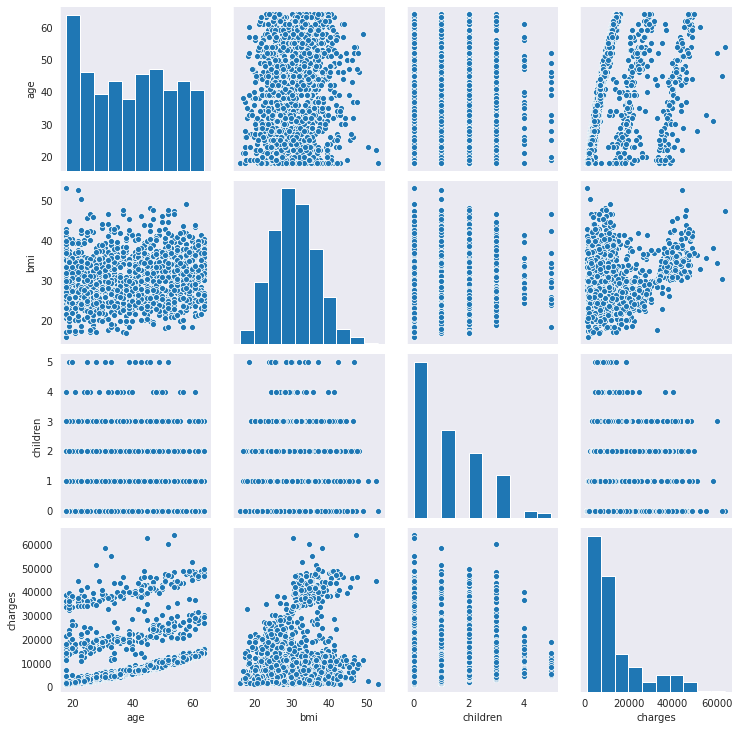

In [ ]:
sns.pairplot(df)

On the second hand, we are going to check the histograms for each feature. This is useful for finding outliers.


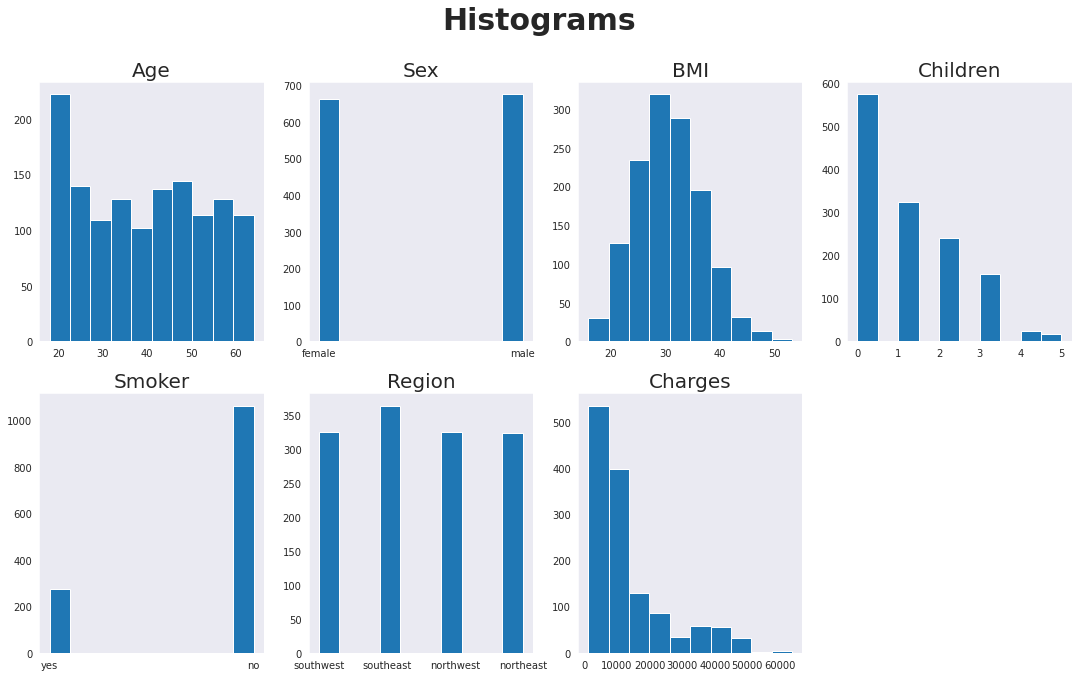

In [ ]:
fig, axs = plt.subplots(2,4)
fig.suptitle('Histograms', fontsize=30, weight = 'bold', y=0.98)
fig.set_size_inches(18.5, 10.5)

axs[0,0].hist(df['age'])
axs[0,0].set_title('Age', size=20)

axs[0,1].hist(df['sex'])
axs[0,1].set_title('Sex', size=20)

axs[0,2].hist(df['bmi'])
axs[0,2].set_title('BMI', size=20)

axs[0,3].hist(df['children'])
axs[0,3].set_title('Children', size=20)

axs[1,0].hist(df['smoker'])
axs[1,0].set_title('Smoker', size=20)

axs[1,1].hist(df['region'])
axs[1,1].set_title('Region', size=20)

axs[1,2].hist(df['charges'])
axs[1,2].set_title('Charges', size=20)

fig.delaxes(axs[1,3])

On this plot we can see the feature "Charges" are concentrated on low values, where most of them are between 0 and 15000 dollars. Also,  the BMI call my attention due to the values are far from the ideal (18.5 to 24.9), and it can indicate overweight or some desease associated to weight. But, it can be a mistake as well, because people with muscles can have a greater value.  

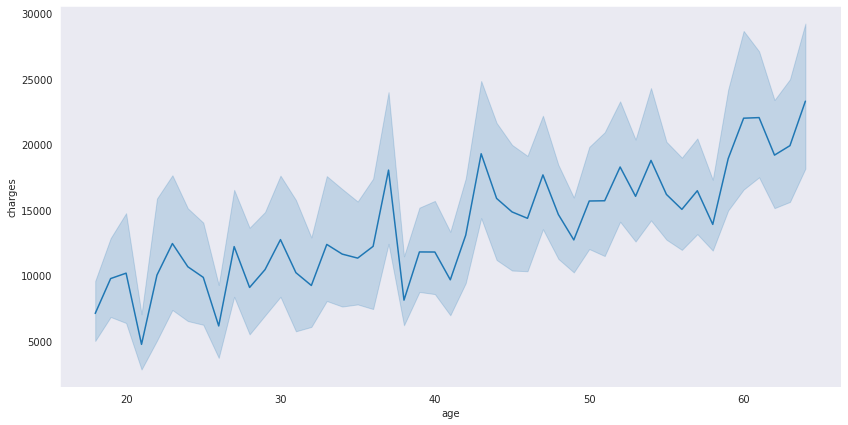

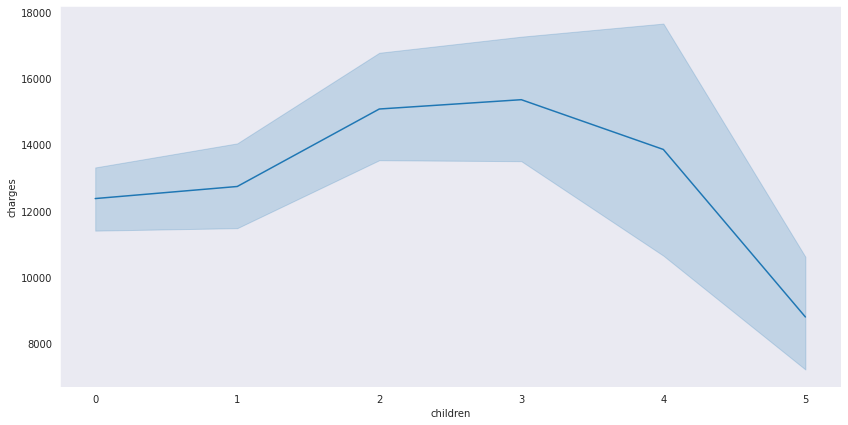

In [ ]:
plt.figure(1, figsize=(14,7))
sns.lineplot(x = 'age', y = 'charges', data = df)


plt.figure(2, figsize=(14,7))
sns.lineplot(x = 'children', y = 'charges', data = df)


After plot this features against the cost of health insurance, we can check that as bigger the age as more expansive is the cost, following an linear line (maybe a linear regression can fit better than other models). Other important observation is the increasing of the cost until 3 children, after it the price starts to decrease. Interesting, isn't it? 

Now, let's check the correlation between the features, using the correlation matrix.

In [ ]:
#getting correlation matrix
corr_matrix = df.corr()
print(corr_matrix)

#getting correlation values for charges sorted
print('\n \nCharges vs Features:')
print(corr_matrix['charges'].sort_values(ascending=False))

               age       bmi  children   charges
age       1.000000  0.109272  0.042469  0.299008
bmi       0.109272  1.000000  0.012759  0.198341
children  0.042469  0.012759  1.000000  0.067998
charges   0.299008  0.198341  0.067998  1.000000

 
Charges vs Features:
charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64


Here we can see the differents features and the correlation with the charges. Age, as we checked before is the most impactful feature and the children is the lowest.

# Feature Engineering

In this section let's try to find some new features using the old ones. There are many cases where the feature engineering helps the model to predict a better result. 

An very useful tool is split the ages into discrete values, which can be represented as a categorical values. This engineering can be a better choice, then we can evaluate the model with categorical ages and after re-test it the real ages. 

*!! After the first attempt, we have checked that categories for age is worse than the number. Let's ignore it for the rest of the model.*



In [ ]:
def age_categories(age):
  if age <= 25:
    return 1
  elif 25 < age <= 40:
    return 2
  elif 40 < age  < 55:
    return 3
  else:
    return 4

In [ ]:
#df ['age_cat'] = df['age'].apply(lambda x: age_categories(x))
#df.drop('age', axis = 1, inplace = True)

For the textual values, like sex, smoker and region, we can use the function getdummies or  do an One Hot Encoding for the categories values. For numerical values, we are going to use standarization.
Let's use this after train test split.

Right! Now let's check if there are any missing value.


In [ ]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

# Split data:

In this section, we are going to split data in 2 sets, train and test! For a better evaluation, we utilise a test set that the model has never seen, it is important for checking if there is some overfitting.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('charges', axis = 1), df['charges'], test_size = 0.25, random_state = 42)

print('Shape of x_train: ', x_train.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of x_test: ', x_test.shape)
print('Shape of y_test: ', y_test.shape)

Shape of x_train:  (1003, 6)
Shape of y_train:  (1003,)
Shape of x_test:  (335, 6)
Shape of y_test:  (335,)


# Transformation pipeline

In [ ]:
num_features = [ 'bmi', 'children','age'] 
cat_features = ['sex', 'smoker', 'region']
#creating pipeline
full_pipeline = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(), cat_features)
])


#applying pipeline on train set
train_prepared = full_pipeline.fit_transform(x_train)
test_prepared = full_pipeline.fit_transform(x_test)

# Baseline:
In this section we are going to model a linear regression for using as baseline for the project due to the simplicity and because age and charge follow a linear trend. For evaluation, RMSE is widely used in predictions cases, due to lower values of RMSE indicate better fit. RMSE is a good measure of how accurately the model predicts the response, and it is the most important criterion for fit if the main purpose of the model is prediction.

In [ ]:
baseline_model = LinearRegression()
baseline_model.fit(train_prepared,y_train)
baseline_preds = baseline_model.predict(train_prepared)
baseline_train_rmse = np.sqrt(mean_squared_error(y_train, baseline_preds))

baseline_test_preds = baseline_model.predict(test_prepared)
baseline_test_rmse = np.sqrt(mean_squared_error(y_test, baseline_test_preds))
print('RMSE for training: ', baseline_train_rmse, '\t','RMSE for testing: ', baseline_test_rmse)

RMSE for training:  6083.132596294014 	 RMSE for testing:  5924.553515748716


# Models evaluation

Let's build some models and evaluate it for the best solution, and we can guide our evaluation by using the baseline RMSE.

For this section, we utilise 4 known methods:

* SVM 
* Random Forest
* XGBoost 
* Decision Tree

In [ ]:


svm_model = svm.SVR(kernel = 'linear')
svm_model.fit(train_prepared, y_train)
svm_train_preds = svm_model.predict(train_prepared)
svm_train_rmse = np.sqrt(mean_squared_error(y_train, svm_train_preds))
svm_test_preds = svm_model.predict(test_prepared)
svm_test_rmse = np.sqrt(mean_squared_error(y_test, svm_test_preds))



RF_model = RandomForestRegressor(n_estimators = 200, random_state = 12 , min_samples_leaf = 32)
RF_model.fit(train_prepared, y_train)
RF_train_preds = RF_model.predict(train_prepared)
RF_train_rmse = np.sqrt(mean_squared_error(y_train, RF_train_preds))
RF_test_preds = RF_model.predict(test_prepared)
RF_test_rmse = np.sqrt(mean_squared_error(y_test, RF_test_preds))



xg_model = XGBRegressor(objective ='reg:linear', learning_rate = 0.01,
                max_depth = 5, n_estimators = 200)
xg_model.fit(train_prepared, y_train)
xg_train_preds = xg_model.predict(train_prepared)
xg_train_rmse = np.sqrt(mean_squared_error(y_train, xg_train_preds))
xg_test_preds = xg_model.predict(test_prepared)
xg_test_rmse = np.sqrt(mean_squared_error(y_test, xg_test_preds))



DT_model = DecisionTreeRegressor(min_samples_leaf=32, random_state = 12)
DT_model.fit(train_prepared, y_train)
DT_train_preds = DT_model.predict(train_prepared)
DT_train_rmse = np.sqrt(mean_squared_error(y_train, DT_train_preds))
DT_test_preds = DT_model.predict(test_prepared)
DT_test_rmse = np.sqrt(mean_squared_error(y_test, DT_test_preds))



print('[SVM] \t RMSE for training: ', svm_train_rmse, '\t','RMSE for testing: ', svm_test_rmse)
print('[RANDOM FOREST] \t RMSE for training: ', RF_train_rmse, '\t','RMSE for testing: ', RF_test_rmse)
print('[XGBOOST] \t RMSE for training: ', xg_train_rmse, '\t','RMSE for testing: ', xg_test_rmse)
print('[Decision Tree] \t RMSE for training: ', DT_train_rmse, '\t','RMSE for testing: ', DT_test_rmse)

table = pd.DataFrame({'Types' : ['Train', 'Test'],
                      'Baseline' :[baseline_train_rmse, baseline_test_rmse],
                      'SVM' : [svm_train_rmse, svm_test_rmse],
                      'Random Forest' : [RF_train_rmse, RF_test_rmse],
                      'XGBOOST' : [xg_train_rmse, xg_test_rmse],
                      'Decision Tree' : [DT_train_rmse, DT_test_rmse]
}).sort_index()

table.set_index('Types').round(1)

[14:28:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[SVM] 	 RMSE for training:  12460.487458798378 	 RMSE for testing:  12677.004023860116
[RANDOM FOREST] 	 RMSE for training:  4457.718452551868 	 RMSE for testing:  4611.906529134968
[XGBOOST] 	 RMSE for training:  4716.2024727720445 	 RMSE for testing:  5120.056779276987
[Decision Tree] 	 RMSE for training:  4336.703996046126 	 RMSE for testing:  4698.978954182641


,Baseline,SVM,Random Forest,XGBOOST,Decision Tree
Types,,,,,
Train,6083.1,12460.5,4457.7,4716.2,4336.7
Test,5924.6,12677.0,4611.9,5120.1,4699.0


# Cross Validation
In this section, we are going to use cross validation. This is a method which splits the dataset in several parts and evaluate the predictions for all of the splits and use the mean for the best model.

In [ ]:

# Function that returns the rmse for each validation
def rmse_scores(model, cv=10):
    neg_error = cross_val_score(model, train_prepared, y_train, 
                           scoring='neg_mean_squared_error', cv=cv)
    return np.sqrt(-neg_error)

# Table of rmse after cross validation
table_scores = pd.DataFrame({
    "RMSE": ['Mean', 'Standard Deviation'],
    "Baseline": [rmse_scores(baseline_model, cv = 10).mean(), rmse_scores(baseline_model, cv = 10).std()],
    "SVM": [rmse_scores(svm_model, cv = 10).mean(), rmse_scores(svm_model, cv = 10).std()],
    "Random Forest": [rmse_scores(RF_model, cv = 10).mean(), rmse_scores(RF_model, cv = 10).std()],
    "XGBoost": [rmse_scores(xg_model, cv = 10).mean(), rmse_scores(xg_model, cv = 10).std()],
    "Decision Tree": [rmse_scores(DT_model, cv = 10).mean(), rmse_scores(DT_model, cv = 10).std()],
    }).sort_index()


table_scores.set_index('RMSE').round(1)

[14:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

,Baseline,SVM,Random Forest,XGBoost,Decision Tree
RMSE,,,,,
Mean,6114.1,12445.5,4728.9,5189.4,4655.3
Standard Deviation,443.3,974.6,561.4,627.1,557.2


After some adjusting about overfitting data, we have reached a very near rmse between train and test, we ara going to choose the best model that is better than our baseline. Then, let's use Decision Tree Regressor! 

# Hyper-Parameters Optimization 

In this section we are going to use an imporatant tool in machine learning projects. Called Random Search, it involves find the best set of hyper-parameters that results in the smallest RMSE. 

In [ ]:
def train_model(params):
  max_depth = params[0]
  min_samples_leaf = params [1]
  min_weight_fraction_leaf = params[2]
  max_leaf_nodes = params[3]

  print (params, '\n')
  dt_model = DecisionTreeRegressor(max_depth = max_depth, min_samples_leaf = min_samples_leaf,
                                   min_weight_fraction_leaf = min_weight_fraction_leaf, max_leaf_nodes = max_leaf_nodes)
  dt_model.fit(train_prepared, y_train)

  preds = dt_model.predict(train_prepared)

  rmse = np.sqrt(mean_squared_error(y_train, preds))
  
  return rmse

In [ ]:
# List with values for the best fit
space = [(1, 9), #max_depth
         (2,128), #min_samples_leaf
         (0, 0.5), # min_weight_fraction_leaf
         (2, 256)] #max_leaf_nodes


result = dummy_minimize(train_model, space, random_state = 12, verbose =1 , n_calls = 30)

Iteration No: 1 started. Evaluating function at random point.
[7, 127, 0.13165750759256736, 5] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0044
Function value obtained: 6706.4415
Current minimum: 6706.4415
Iteration No: 2 started. Evaluating function at random point.
[4, 78, 0.17523913800249627, 51] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0039
Function value obtained: 6775.4835
Current minimum: 6706.4415
Iteration No: 3 started. Evaluating function at random point.
[5, 7, 0.0167107138131723, 164] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0053
Function value obtained: 4241.0681
Current minimum: 4241.0681
Iteration No: 4 started. Evaluating function at random point.
[7, 76, 0.14191417647897295, 106] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0035
Function value obtained: 6706.4415
Current minimum: 4241.0681
Iteration No: 5 started. Evaluating function at random point.
[3

In [ ]:
best_params = pd.DataFrame({
    'Evaluation' : ['Best Parameters'],
    'max_depth' : result.x[0],
    'min_samples_leaf' : result.x[1],
    'min_weight_fraction_leaf' : result.x[2],
    'max_leaf_nodes' : result.x[3]
}).sort_index()

best_params.set_index('Evaluation')

,max_depth,min_samples_leaf,min_weight_fraction_leaf,max_leaf_nodes
Evaluation,,,,
Best Parameters,5,8,0.010405,75


# Deploy
After evaluating the best model, we are going to dump the model file for creating an useful application. This part of the project is not inside the notebook, but after the deployment, I will paste some pictures here for demonstration. Also, the final part is available on github along with the notebook.

In [ ]:
# Dump the final model
final_model_dt = DecisionTreeRegressor(max_depth = 5, min_samples_leaf = 8,
                                   min_weight_fraction_leaf = 0.010405, max_leaf_nodes = 75)

final_model_dt.fit(train_prepared, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=75,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.010405, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
#joblib.dump(full_pipeline, 'pipeline.pkl')

['pipeline.pkl']

In [ ]:
#joblib.dump(final_model_dt, 'final_model.pkl')

['final_model.pkl']

Final application working!


<center>

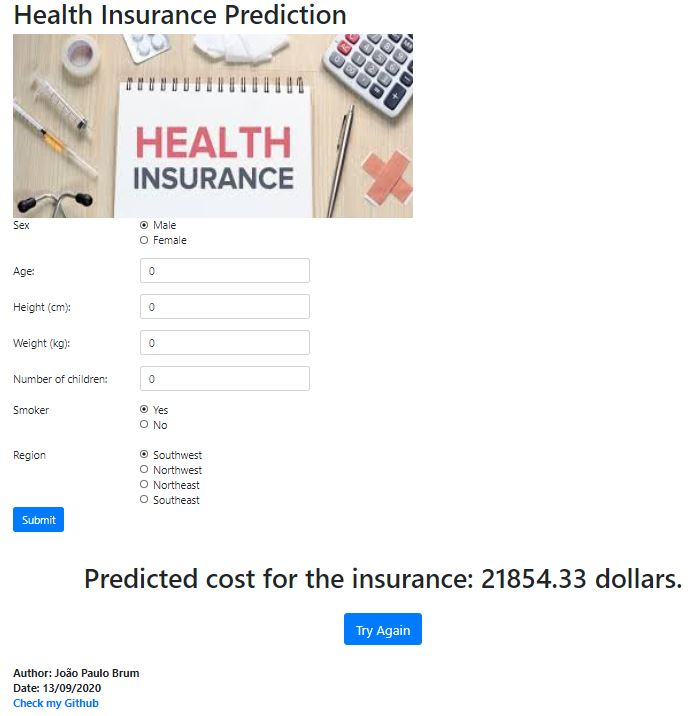


</center>
